## NIH Chest X-ray Balanced Subset
This dataset is a balanced subset of the original NIH ChestX-ray14 dataset, curated to support fair training and evaluation of medical imaging models, especially for multi-label chest disease classification tasks.

###  What's Inside
nih_balanced_images/:
Contains filtered and copied image files (in .png format) from the original NIH dataset, stored in a single folder.

nih_final_df_cleaned.csv:
A CSV file containing metadata for each image, including:

Image Index

Finding Labels

Other NIH-provided attributes (age, gender, view position, etc.)

### Dataset Selection Criteria
To construct this balanced subset:

Exactly 1,000 samples per disease label were selected (as much as available).

All 227 Hernia samples are included (due to scarcity).

4,000 samples of "No Finding" were included to reflect common clinical cases but avoid dominance.

Multi-label samples were preserved (i.e., images may appear in multiple disease counts).

Duplicates and missing files were filtered out.

Final label frequencies were plotted and verified for balance.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [2]:
df['Finding Labels'] = df['Finding Labels'].str.replace('No Finding','No_Finding')

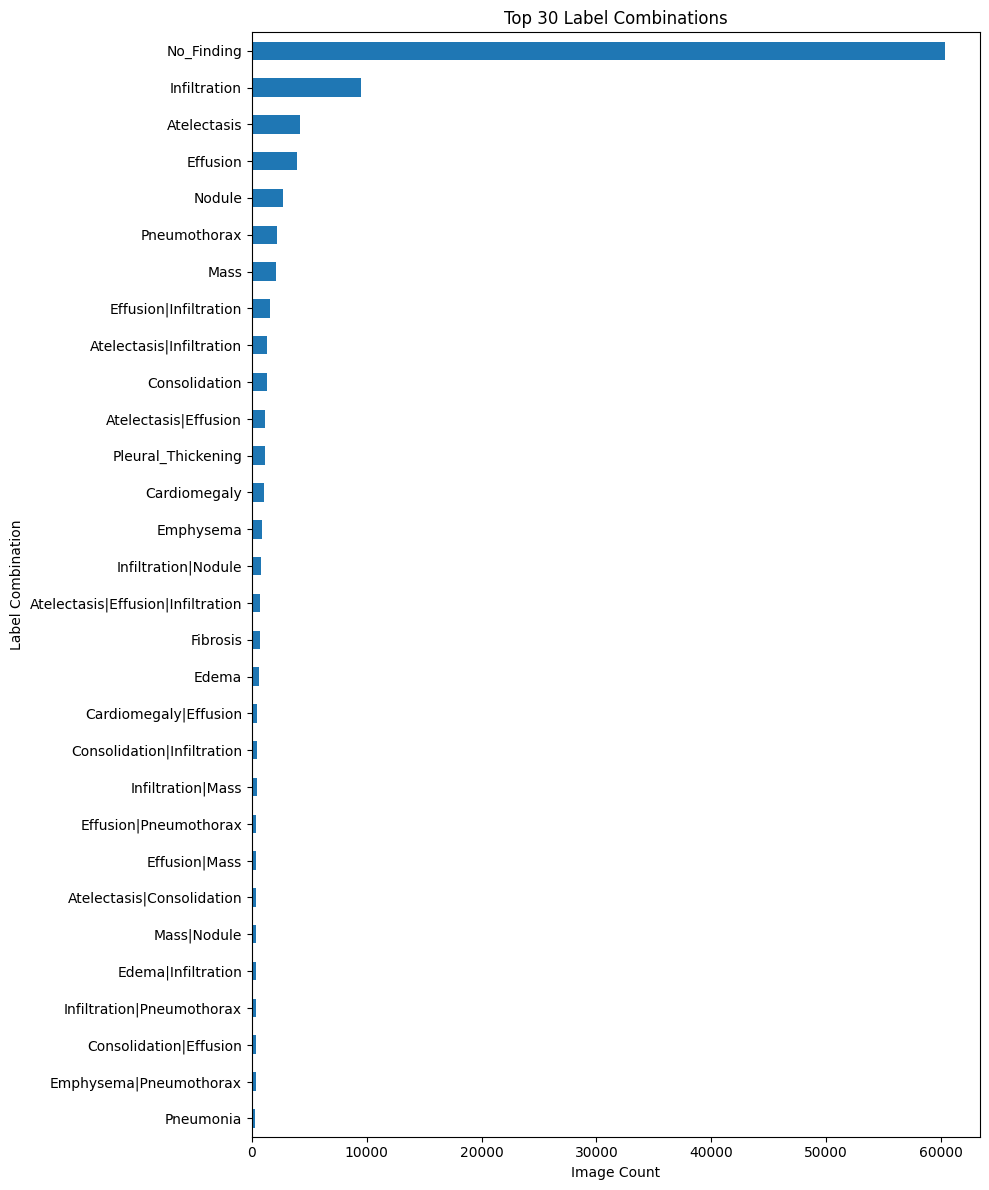

In [3]:
import matplotlib.pyplot as plt

combo_counts = df["Finding Labels"].value_counts().head(30) 
combo_counts.plot(kind='barh', figsize=(10, 12), title="Top 30 Label Combinations")
plt.xlabel("Image Count")
plt.ylabel("Label Combination")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [4]:
unique_dieases_list = df['Finding Labels'].unique()
unique_names = []

for name in unique_dieases_list:
    if "|" in name:
        labels = name.split('|')
        for name2 in labels:
            if name2 not in unique_names:
                unique_names.append(name2)
    else:
        if name not in unique_names:
            unique_names.append(name)

unique_names

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'No_Finding',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

In [6]:
from collections import Counter

labels = df['Finding Labels'].tolist()
all_labels = []
for label_str in labels:
    labels = label_str.split('|')
    all_labels.extend(labels)

label_counts = Counter(all_labels)

label_counts

Counter({'Cardiomegaly': 2776,
         'Emphysema': 2516,
         'Effusion': 13317,
         'No_Finding': 60361,
         'Hernia': 227,
         'Infiltration': 19894,
         'Mass': 5782,
         'Nodule': 6331,
         'Atelectasis': 11559,
         'Pneumothorax': 5302,
         'Pleural_Thickening': 3385,
         'Pneumonia': 1431,
         'Fibrosis': 1686,
         'Edema': 2303,
         'Consolidation': 4667})

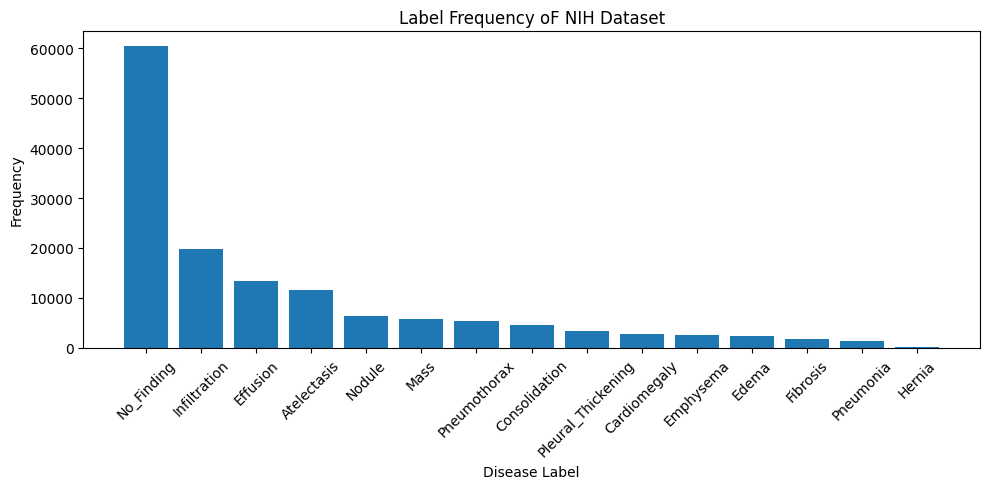

In [7]:
labels, counts = zip(*sorted(label_counts.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.xlabel("Disease Label")
plt.ylabel("Frequency")
plt.title("Label Frequency oF NIH Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
import random
from collections import defaultdict, Counter

label_to_indices = defaultdict(list)
for i, row in df.iterrows():
    for label in row["Finding Labels"].split("|"):
        label_to_indices[label].append(i)

target_per_class = 1000
final_indices = set()

for label, indices in label_to_indices.items():
    unique_indices = list(set(indices))  
    random.shuffle(unique_indices)

    if label == "Hernia":
        selected = unique_indices 
    elif label == "No_Finding":
        selected = unique_indices[:4000]
    else:
        selected = unique_indices[:target_per_class]

    for idx in selected:
        final_indices.add(idx)


In [9]:
final_df = df.loc[list(final_indices)].reset_index(drop=True)

all_labels = []
for lbl_str in final_df["Finding Labels"]:
    all_labels.extend(lbl_str.split("|"))
print(Counter(all_labels))


Counter({'No_Finding': 4000, 'Infiltration': 3669, 'Effusion': 3245, 'Atelectasis': 2643, 'Mass': 1771, 'Nodule': 1701, 'Pneumothorax': 1653, 'Consolidation': 1610, 'Pleural_Thickening': 1391, 'Edema': 1274, 'Emphysema': 1226, 'Cardiomegaly': 1214, 'Pneumonia': 1104, 'Fibrosis': 1069, 'Hernia': 227})


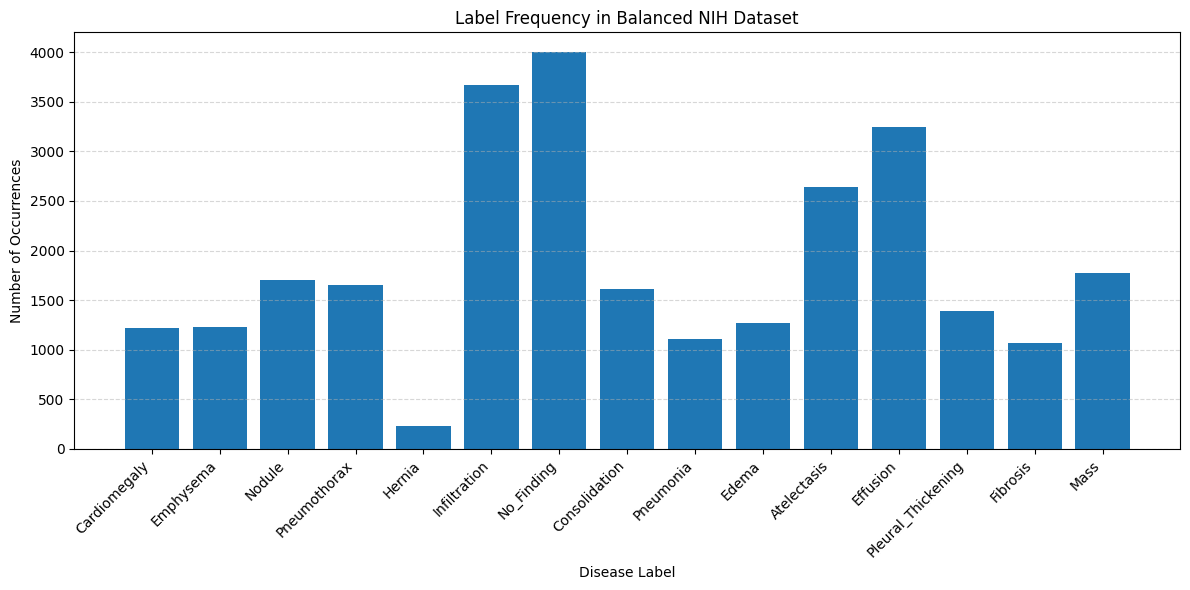

In [10]:
final_df = df.loc[list(final_indices)].reset_index(drop=True)

all_labels = []
for lbl_str in final_df["Finding Labels"]:
    all_labels.extend(lbl_str.split("|"))

label_counts = Counter(all_labels)

plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title("Label Frequency in Balanced NIH Dataset")
plt.xlabel("Disease Label")
plt.ylabel("Number of Occurrences")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [11]:
final_df.sample(20)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
8563,00003950_002.png,Pneumonia,2,3950,40,M,PA,2500,2048,0.168000,0.168000,NaN
5807,00018536_001.png,Nodule,1,18536,74,M,PA,3056,2544,0.139000,0.139000,NaN
758,00016508_044.png,Consolidation,44,16508,51,F,AP,2500,2048,0.168000,0.168000,NaN
5024,00002275_018.png,Emphysema|Infiltration|Pneumonia,18,2275,65,M,PA,2992,2991,0.143000,0.143000,NaN
7962,00011859_010.png,No_Finding,10,11859,52,M,AP,2500,2048,0.168000,0.168000,NaN
7752,00030570_004.png,Edema,4,30570,29,F,AP,3056,2544,0.139000,0.139000,NaN
10671,00021110_002.png,Cardiomegaly|Pneumothorax,2,21110,51,F,PA,2992,2901,0.143000,0.143000,NaN
10788,00005435_004.png,No_Finding,4,5435,58,F,PA,2048,2500,0.171000,0.171000,NaN
13979,00014888_002.png,Infiltration|Nodule,2,14888,43,M,PA,2500,2048,0.168000,0.168000,NaN
5104,00018248_000.png,Cardiomegaly|Effusion,0,18248,49,M,PA,2778,2507,0.143000,0.143000,NaN


In [12]:
print("Total rows in final_df:", len(final_df))

Total rows in final_df: 16106


In [ ]:
final_df.to_csv("nih_balanced_filtered.csv", index=False)

## Now Create Image Folder to Copy All the images in to single folder

In [ ]:
import os
import shutil
from tqdm import tqdm

source_root = "/kaggle/input/data"
target_dir = "nih_balanced_images"
os.makedirs(target_dir, exist_ok=True)

image_names = final_df["Image Index"].tolist()

for img_name in tqdm(image_names):
    found = False
    for folder_num in range(1, 13):
        folder_path = os.path.join(source_root, f"images_{folder_num:03d}", "images")
        src_path = os.path.join(folder_path, img_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, os.path.join(target_dir, img_name))
            found = True
            break
    if not found:
        print(f"Image not found: {img_name}")
